# In this Notebook i will explore how to build a eficient dataloader for the metagenomics LLM models

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns 
import matplotlib.pyplot as plt




First im just loading the data: 
* samples-otus-99-filtered-matrix.npz: its an array wiht shape [Samples X otus_abundances]
* matrix_samples: its a text file with the code of each samples (names of the rows)
* matrix_taxa_with_taxonomy: names of the taxonomi columns 


In [2]:

matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz"
samples_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_samples.txt"
taxonomy_names_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa_with_taxonomy.txt"
df_taxonomy = pd.read_csv(taxonomy_names_path, sep="\t", header=None, names=["OTU_ID", "taxonomy"])
df_taxonomy.loc[
    df_taxonomy["OTU_ID"] == "90_668;96_3619;97_4447;98_5703;99_7803", 
    "taxonomy"
] = "d__Eukaryota;p__Discoba;c__Heterolobosea;o__Tetramitia;f__Vahlkampfiidae;g__Naegleria;s__Naegleria_fowleri"

# Load the matrix
X = sp.load_npz(matrix_path)  # shape (N_samples, N_features)

# Load the sample IDs in the same row order
with open(samples_txt, "r") as f:
    sample_ids = [line.strip() for line in f]

print("Matrix shape:", X.shape)
print("Number of rows (samples):", len(sample_ids))
print("Number of columns (OTUs):", len(df_taxonomy))


Matrix shape: (1836255, 148615)
Number of rows (samples): 1836255
Number of columns (OTUs): 148615


Some OTUS share the same taxonomi, i'm mergin the abundance of the repeated taxonomies

In [3]:

# Step 1: Create Taxonomy Mapping
taxonomy_list = df_taxonomy["taxonomy"].unique()  # Unique taxonomies
taxonomy_index = {tax: i for i, tax in enumerate(taxonomy_list)}  # Map taxonomy to index
otu_index = {otu: i for i, otu in enumerate(df_taxonomy["OTU_ID"])}  # OTU to column index in X

# Step 2: Build Sparse Mapping Matrix (OTU → Taxonomy)
num_otus = len(df_taxonomy)
num_taxonomies = len(taxonomy_list)

# Sparse matrix shape (num_otus, num_taxonomies)
otu_to_taxonomy_matrix = sp.lil_matrix((num_otus, num_taxonomies))

for otu, tax in zip(df_taxonomy["OTU_ID"], df_taxonomy["taxonomy"]):
    otu_idx = otu_index[otu]
    tax_idx = taxonomy_index[tax]
    otu_to_taxonomy_matrix[otu_idx, tax_idx] = 1  # Assign OTU to corresponding taxonomy

otu_to_taxonomy_matrix = otu_to_taxonomy_matrix.tocsr()  # Convert to CSR for fast matrix multiplication

# Step 3: Aggregate OTU abundances by multiplying matrices
X_taxonomy = X @ otu_to_taxonomy_matrix  # (samples x OTUs) * (OTUs x Taxonomies) = (samples x Taxonomies)

# Step 4: Save New Matrix
taxonomy_matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz"
sp.save_npz(taxonomy_matrix_path, X_taxonomy)

taxonomy_mapping_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv"
df_taxonomy_mapping = pd.DataFrame({"taxonomy": taxonomy_list})
df_taxonomy_mapping.to_csv(taxonomy_mapping_path, index=False)

print(f"✅ Optimized! Transformed OTU matrix to Taxonomy matrix with shape {X_taxonomy.shape}")
print(f"✅ Saved taxonomy matrix to: {taxonomy_matrix_path}")
print(f"✅ Saved taxonomy mapping to: {taxonomy_mapping_path}")

✅ Optimized! Transformed OTU matrix to Taxonomy matrix with shape (1836255, 8533)
✅ Saved taxonomy matrix to: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz
✅ Saved taxonomy mapping to: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv


In [4]:
# Select the first sample (index 0)
sample_index = 0

# Get non-zero OTUs for the first sample
nonzero_otu_indices = X[sample_index].nonzero()[1]  # Get OTU indices
nonzero_otu_values = X[sample_index, nonzero_otu_indices].toarray().flatten()  # Convert to array

# Get non-zero taxonomies for the first sample
nonzero_tax_indices = X_taxonomy[sample_index].nonzero()[1]  # Get taxonomy indices
nonzero_tax_values = X_taxonomy[sample_index, nonzero_tax_indices].toarray().flatten()  # Convert to array

# Retrieve OTU IDs and Taxonomy Names
otus = [df_taxonomy.iloc[i]["taxonomy"] for i in nonzero_otu_indices]
taxonomies = [taxonomy_list[i] for i in nonzero_tax_indices]  # taxonomy_list should contain unique taxonomies

# Display results
print("\n🔹 Non-Zero OTUs in Sample 1:")
for otu, value in zip(otus, nonzero_otu_values):
    print(f"  - {otu}: {value}")

print("\n🔹 Non-Zero Taxonomies in Sample 1:")
for tax, value in zip(taxonomies, nonzero_tax_values):
    print(f"  - {tax}: {value}")


🔹 Non-Zero OTUs in Sample 1:
  - d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium_A;s__Fusobacterium_A: 0.00641025641025641
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae: 0.01282051282051282
  - d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae: 0.009615384615384616
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Massiliomicrobiota;s__Massiliomicrobiota: 0.01282051282051282
  - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_A;s__Bacteroides_A: 0.01282051282051282
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter: 0.27564102564102566
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter: 0.5512820512820513
  - d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Pepto

0.95 quantile of taxonomies per sample: 104.00
[11 81 84 ... 36 34 28]


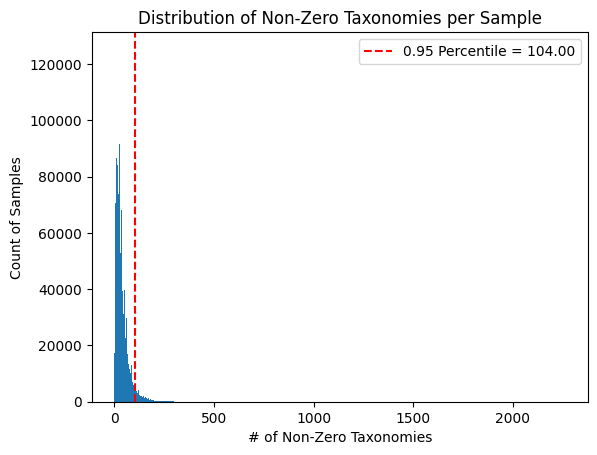

In [10]:
num_non_zero_taxonomies = X_taxonomy.getnnz(axis=1)  # shape: (num_samples,)


pct_5_value = np.quantile(num_non_zero_taxonomies, 0.95)# Step 3: Plot histogram
print(f"0.95 quantile of taxonomies per sample: {pct_5_value:.2f}")
print(num_non_zero_taxonomies)

plt.hist(num_non_zero_taxonomies, bins=1000 )
plt.title("Distribution of Non-Zero Taxonomies per Sample")
plt.xlabel("# of Non-Zero Taxonomies")
plt.ylabel("Count of Samples")

# Step 4: Add vertical line at the 5th percentile
plt.axvline(
    x=pct_5_value, 
    color="red", 
    linestyle="--", 
    label=f"0.95 Percentile = {pct_5_value:.2f}"
)

plt.legend()
plt.show()

# dataloader testing, basic dataloader

In [5]:
import time
import torch
from torch.utils.data import Dataset as TorchDataset

from torch.utils.data import DataLoader
from ete3 import Tree, TreeStyle
from ploting_trees import build_taxa_dict, dict_to_ete3, my_layout_fn

In [6]:
class TaxonomyDataset(TorchDataset):
    def __init__(self, X, X_taxonomy, df_taxonomy, taxonomy_list, max_taxa=104, return_abundances=False):
        """
        Args:
            X (scipy.sparse matrix): Matrix of OTUs (num_samples x num_otus).
            X_taxonomy (scipy.sparse matrix): Matrix of taxonomies (num_samples x num_taxonomies).
            df_taxonomy (pandas.DataFrame): Contains mapping from OTU indices to taxonomy strings.
            taxonomy_list (list): Unique taxonomy strings for columns in X_taxonomy.
            max_taxa (int): Fixed length to pad/truncate each sample's taxonomy list.
        """
        super().__init__()
        self.X = X
        self.X_taxonomy = X_taxonomy
        self.df_taxonomy = df_taxonomy
        self.taxonomy_list = taxonomy_list
        self.max_taxa = max_taxa
        self.num_samples = X.shape[0]
        self.return_abundances = return_abundances


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Returns:
            A single list of taxonomies of length 'max_taxa', sorted by abundance (descending),
            padded (with '<pad>') or truncated if necessary.
        """
        # 1) Identify non-zero taxonomy indices + values
        nonzero_tax_indices = self.X_taxonomy[idx].nonzero()[1]
        nonzero_tax_values  = self.X_taxonomy[idx, nonzero_tax_indices].toarray().flatten()
        taxonomies = [self.taxonomy_list[i] for i in nonzero_tax_indices]

        # 2) Pair each taxonomy with its abundance, then sort descending
        tax_val_pairs = list(zip(taxonomies, nonzero_tax_values))
        tax_val_pairs_sorted = sorted(tax_val_pairs, key=lambda x: x[1], reverse=True)

        # 3) Keep only the sorted taxonomy names
        sorted_taxonomies = [tv[0] for tv in tax_val_pairs_sorted]
        sorted_abundances = [tv[1] for tv in tax_val_pairs_sorted]

		# 4) Pad or truncate to 'max_taxa'
        cur_len = len(sorted_taxonomies)
        if cur_len < self.max_taxa:
            pad_len = self.max_taxa - cur_len
            sorted_taxonomies += ["<pad>"] * pad_len
            sorted_abundances += [0.0] * pad_len
        elif cur_len > self.max_taxa:
            sorted_taxonomies = sorted_taxonomies[:self.max_taxa]
            sorted_abundances = sorted_abundances[:self.max_taxa]

        # 5) Return depending on 'return_abundances'
        if self.return_abundances:
            return {
                "taxonomies": sorted_taxonomies,
                "abundances": sorted_abundances,
            }
        else:
            return sorted_taxonomies
def no_collation(batch):
    # 'batch' will be a list of length = batch_size
    # each element is exactly what your Dataset's __getitem__ returned
    # i.e. a list of (up to) 104 strings.
    # Just return it directly:
    return batch

In [47]:

# Create the dataset instance
dataset = TaxonomyDataset(
    X=X,
    X_taxonomy=X_taxonomy,
    df_taxonomy=df_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=65,
    return_abundances=True,
)

# Create a DataLoader with any batch size
data_loader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=no_collation)
# Let's see what a batch looks like
for batch_idx, batch_taxa in enumerate(data_loader):
    # 'batch_taxa' is now a list of length == batch_size.
    # Each element is a list of 104 taxonomies (sorted and padded).
    print(f"Batch #{batch_idx}, batch size: {len(batch_taxa)}")
    for sample_idx, tax_list in enumerate(batch_taxa):
        print(f"  Sample {sample_idx} in this batch:")
        print("  ", tax_list)
    break  # Just show the first batch

Batch #0, batch size: 2
  Sample 0 in this batch:
   {'taxonomies': ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Paeniclostridium;s__Paeniclostridium', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus_M;s__Lactobacillus_M', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_A;s__Bacteroides_A', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Massiliomicrobiota;s__Massiliomicrobiota', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Intestinibacter;s__Intestinibacter

In [78]:

# Create your dataset and DataLoader (batch_size, shuffle, etc.) 
dataset = TaxonomyDataset(X, X_taxonomy, df_taxonomy, taxonomy_list)
data_loader = DataLoader(dataset, batch_size=512, shuffle=False, collate_fn=no_collation)

start_time = time.time()
sample_count = 0

for batch_idx, batch in enumerate(data_loader):
    # 'batch' here is a list of length = batch_size (2 in this example).
    sample_count += len(batch)  # increment by batch_size

    # Print time every 10,000 samples
    if sample_count % 10_000 == 0:
        current_time = time.time()
        elapsed_part = current_time - start_time
        print(f"Processed {sample_count} samples in {elapsed_part:.2f} seconds...")

# End of iteration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total samples processed: {sample_count}")
print(f"Time taken to load the entire dataset: {elapsed_time:.2f} seconds")

Processed 320000 samples in 56.66 seconds...
Processed 640000 samples in 113.45 seconds...
Processed 960000 samples in 170.29 seconds...
Processed 1280000 samples in 226.99 seconds...
Processed 1600000 samples in 283.83 seconds...
Total samples processed: 1836255
Time taken to load the entire dataset: 325.93 seconds


In [48]:
def build_prefix_tree(taxonomies, abundances):
    """
    Returns a nested dictionary, merging shared prefixes but *without* summing abundances.
    Each leaf node has:
      {
        "_is_leaf": True,
        "_abundance": <float>
      }
    For example, if one path stops at 'f__X' with abundance 0.1
    and another path continues down to 'g__Y' with abundance 0.2,
    'f__X' becomes a leaf in the dictionary, and 'g__Y' is a sub-node.
    """
    tree_dict = {}

    for tax_str, ab in zip(taxonomies, abundances):
        if not tax_str or tax_str == "<pad>":
            # Skip empty or padding
            continue
        
        ranks = tax_str.split(";")  # e.g. ['d__Bacteria', 'p__Firmicutes', ...]
        node = tree_dict

        for i, rank in enumerate(ranks):
            if rank not in node:
                node[rank] = {}  # create child
            # If this is the final rank (a leaf in this path)
            if i == len(ranks) - 1:
                node[rank]["_is_leaf"] = True
                node[rank]["_abundance"] = ab
            # Move deeper
            node = node[rank]

    return tree_dict


In [49]:
# 1) Set up your dataset & loader
dataset = TaxonomyDataset(
    X=X,
    X_taxonomy=X_taxonomy,
    df_taxonomy=df_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=65,
    return_abundances=True,
)

data_loader = DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=no_collation
)


for batch_idx, batch in enumerate(data_loader):
    sample_dict = batch[0]  # {"taxonomies": [...], "abundances": [...]}
    taxonomies = sample_dict["taxonomies"]
    abundances = sample_dict["abundances"]

    # Build the prefix tree for this sample
    prefix_tree = build_prefix_tree(taxonomies, abundances)

    # Convert to an ete3 Tree
    ete_tree = dict_to_ete3(prefix_tree, node_name="Root")

    # Set up a TreeStyle with our layout function
    ts = TreeStyle()
    ts.layout_fn = my_layout_fn
    # Hide default leaf names, since we have custom labels
    ts.show_leaf_name = False
    ts.show_branch_length = False

    # Show or save the tree
    ete_tree.show(tree_style=ts)              # Interactive (if your environment supports it)
    ete_tree.render("sample0_no_sum_tree.png", tree_style=ts)  # Save to file
    break


In [88]:
print(f"fidding the full dataset takes {325.93 /60} min")

fidding the full dataset takes 5.432166666666666 min


# Dataloader that can colapse in different tree levels

In [12]:
def truncate_taxonomy_up_to_rank(taxonomy_str, rank_code="f"):
    """
    Given a full taxonomy like:
      d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter
    and a rank_code like 'f', return:
      'd__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae'
    If the rank_code is not found, return the original string.
    """
    parts = taxonomy_str.split(';')
    # parts = [
    #   'd__Bacteria', 'p__Firmicutes', 'c__Bacilli', 
    #   'o__Haloplasmatales', 'f__Turicibacteraceae', 
    #   'g__Turicibacter', 's__Turicibacter'
    # ]

    # We look for the first part that starts with e.g. 'f__'
    target_prefix = rank_code + "__"

    truncated_parts = []
    for p in parts:
        truncated_parts.append(p)
        if p.startswith(target_prefix):
            # Stop once we've included the target rank
            break

    return ";".join(truncated_parts)

import random

def collapse_taxa_up_to_rank(taxonomies, abundances, possible_ranks=("p","c","o","f","g","s"), randomize=True):
    """
    taxonomies: list of full taxonomy strings (e.g. d__...;p__...;...;s__...)
    abundances: same-length list of abundance floats
    possible_ranks: which ranks we might choose from
    randomize: if True, pick one rank randomly each time; 
               otherwise, pick e.g. the *last* in possible_ranks or a fixed rank

    Returns:
      collapsed_tax_list, collapsed_abundance_list
    """
    if randomize:
        rank_code = random.choice(possible_ranks)
    else:
        rank_code = possible_ranks[-1]  # or a fixed choice

    # Dictionary to accumulate sums
    collapsed_map = {}

    for tax_str, ab in zip(taxonomies, abundances):
        # 1) Truncate up to the chosen rank
        truncated = truncate_taxonomy_up_to_rank(tax_str, rank_code)

        # 2) Sum abundance for identical truncated taxonomies
        collapsed_map[truncated] = collapsed_map.get(truncated, 0.0) + ab

    # Convert to lists
    collapsed_tax_list = list(collapsed_map.keys())
    collapsed_abundance_list = list(collapsed_map.values())
    return collapsed_tax_list, collapsed_abundance_list


class CollapsingTaxonomyDataset(TorchDataset):
    def __init__(
        self,
        X_taxonomy,
        taxonomy_list,
        max_taxa=104,
        ranks=('p','c','o','f','g','s'),
        do_augmentation=True
    ):
        """
        Args:
          X_taxonomy: SciPy sparse matrix (num_samples x num_taxonomies).
          taxonomy_list: List of strings, each is a full taxonomy string for a column in X_taxonomy.
          max_taxa: how many to pad/truncate to
          ranks: tuple/list of rank codes for random collapsing (p, c, o, f, g, s)
          do_augmentation: if True, pick a random rank each time; 
                           if False, do no collapse (or a fixed approach).
        """
        super().__init__()
        self.X_taxonomy = X_taxonomy
        self.taxonomy_list = taxonomy_list
        self.max_taxa = max_taxa
        self.ranks = ranks
        self.do_augmentation = do_augmentation
        self.num_samples = X_taxonomy.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 1) Non-zero indices + values
        nonzero_tax_indices = self.X_taxonomy[idx].nonzero()[1]
        nonzero_tax_values  = self.X_taxonomy[idx, nonzero_tax_indices].toarray().flatten()
        
		# # debugging:
        # # Let's check if all are strings:
        # for i, t in zip(nonzero_tax_indices, taxonomies):
        #     if not isinstance(t, str):
        #         print(f"Index {i} yields a non-string taxonomy: {t} (type={type(t)})")
		# 		# You could raise an error or skip here:
		# 		# raise ValueError(f"Taxonomy {i} is not a string!")`



		###############

        # Original full taxonomies
        original_taxa = [self.taxonomy_list[i] for i in nonzero_tax_indices]

        # 2) Maybe collapse at random rank
        if self.do_augmentation:
            collapsed_taxa, collapsed_ab = collapse_taxa_up_to_rank(
                original_taxa, nonzero_tax_values,
                possible_ranks=self.ranks,
                randomize=True
            )
        else:
            # No augmentation => keep original
            collapsed_taxa, collapsed_ab = original_taxa, nonzero_tax_values

        # 3) Sort by abundance descending
        tax_val_pairs = list(zip(collapsed_taxa, collapsed_ab))
        tax_val_pairs_sorted = sorted(tax_val_pairs, key=lambda x: x[1], reverse=True)

        sorted_taxonomies  = [p[0] for p in tax_val_pairs_sorted]
        sorted_abundances  = [p[1] for p in tax_val_pairs_sorted]

        # 4) Pad or truncate
        cur_len = len(sorted_taxonomies)
        if cur_len < self.max_taxa:
            pad_len = self.max_taxa - cur_len
            sorted_taxonomies += ["<pad>"] * pad_len
            sorted_abundances += [0.0] * pad_len
        elif cur_len > self.max_taxa:
            sorted_taxonomies = sorted_taxonomies[:self.max_taxa]
            sorted_abundances = sorted_abundances[:self.max_taxa]

        # Return both
        return {
            "taxonomies": sorted_taxonomies,
            "abundances": sorted_abundances
        }

In [ ]:
{'taxonomies': ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter', 
                'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Paeniclostridium;s__Paeniclostridium', 
                'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus_M;s__Lactobacillus_M', 
                'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium', 
                'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_A;s__Bacteroides_A', 
                'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Massiliomicrobiota;s__Massiliomicrobiota', 
                'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae', 
                'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Intestinibacter;s__Intestinibacter', 
                'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae', 
                'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales', 
                'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium_A;s__Fusobacterium_A', 
                '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 
 'abundances': [0.826923076923077, 
                0.06623931623931624, 
                0.019230769230769232, 
                0.016025641025641024, 
                0.01282051282051282, 
                0.01282051282051282, 
                0.01282051282051282, 
                0.010683760683760684, 
                0.009615384615384616, 
                0.00641025641025641, 
                0.00641025641025641, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In [13]:

dataset = CollapsingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=104,
    ranks=('p','c','o','f','g','s'),
    do_augmentation=True  # pick random rank each time
)


data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=no_collation
)

for batch_idx, batch in enumerate(data_loader):
    # batch is a list of 2 samples (dicts)
    # each sample has "taxonomies" + "abundances"
    sample0 = batch[0]
    print("Taxonomies up to random rank (sample0):", sample0["taxonomies"])
    print("Abundances (sample0):", sample0["abundances"])
    break

Taxonomies up to random rank (sample0): ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales', 'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

In [58]:

dataset = CollapsingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=104,
    ranks=('p','c','o','f','g','s'),
    do_augmentation=True  # pick random rank each time
)

data_loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=False,
    collate_fn=no_collation
)

start_time = time.time()
sample_count = 0

for batch_idx, batch in enumerate(data_loader):
    # 'batch' is a list of items, where len(batch) == batch_size (except possibly the last batch)
    sample_count += len(batch)

    # Print intermediate timing every 10,000 samples
    if sample_count % 10_000 == 0:
        current_time = time.time()
        elapsed_part = current_time - start_time
        print(f"Processed {sample_count} samples in {elapsed_part:.2f} seconds...")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total samples processed: {sample_count}")
print(f"Time taken to load the entire dataset: {elapsed_time:.2f} seconds")

Processed 320000 samples in 68.36 seconds...
Processed 640000 samples in 136.97 seconds...
Processed 960000 samples in 205.40 seconds...
Processed 1280000 samples in 273.68 seconds...
Processed 1600000 samples in 342.30 seconds...
Total samples processed: 1836255
Time taken to load the entire dataset: 393.41 seconds


In [14]:
# show tree of a sample
dataset = CollapsingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=104,
    ranks=('p','c','o','f','g','s'),
    do_augmentation=True  # pick random rank each time
)

data_loader = DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=no_collation
)


for batch_idx, batch in enumerate(data_loader):
    sample_dict = batch[0]  # {"taxonomies": [...], "abundances": [...]}
    taxonomies = sample_dict["taxonomies"]
    abundances = sample_dict["abundances"]
    
	## print the sorted taxas
    sample0 = batch[0]
    print("Taxonomies up to random rank (sample0):", sample0["taxonomies"])
    print("Abundances (sample0):", sample0["abundances"])   
	

    # Build the prefix tree for this sample
    prefix_tree = build_taxa_dict(taxonomies, abundances)

    # Convert to an ete3 Tree
    ete_tree = dict_to_ete3(prefix_tree, node_name="Root")

    # Set up a TreeStyle with our layout function
    ts = TreeStyle()
    ts.layout_fn = my_layout_fn
    # Hide default leaf names, since we have custom labels
    ts.show_leaf_name = False
    ts.show_branch_length = False

    # Show or save the tree
    ete_tree.show(tree_style=ts)              # Interactive (if your environment supports it)
    ete_tree.render("dataloader2.png", tree_style=ts)  # Save to file
    break


Taxonomies up to random rank (sample0): ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales', 'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

inotify_add_watch(/home/hernan_melmoth/.config/ibus/bus/82c56c1f31544110ad3efd631d0396eb-unix-0) failed: (No space left on device)


# Dataloader that colapse trees randomly 

In [9]:
import random

def random_collapse_per_path(taxonomies, abundances, possible_ranks=('p','c','o','f','g','s')):
    """
    For each taxonomy path (e.g., d__...;p__...;c__...), pick a random rank from 'possible_ranks'
    that actually appears in that path. Truncate the taxonomy at that rank, merging everything below.
    
    Then group (sum) all truncated paths that ended up identical.
    
    Args:
        taxonomies: list of taxonomy strings
        abundances: parallel list of floats
        possible_ranks: tuple of rank codes (e.g. 'p','c','o','f','g','s')
        
    Returns:
        collapsed_tax_list, collapsed_abundance_list
    """

    collapsed_map = {}

    for tax_str, ab in zip(taxonomies, abundances):
        # Parse the path
        ranks = tax_str.split(';')  # e.g. ["d__Bacteria", "p__Firmicutes", "c__Bacilli", ...]

        # Find which ranks in possible_ranks are actually present in this path
        # e.g. "p__Firmicutes" => rank_code = 'p'
        candidate_positions = []
        for i, r in enumerate(ranks):
            # e.g. r might be "p__Firmicutes"
            # rank_code is what's before "__"
            if '__' in r:
                code = r.split('__', 1)[0]  # "p"
                if code in possible_ranks:
                    candidate_positions.append(i)

        if len(candidate_positions) == 0:
            # No overlap with the chosen ranks => keep full path as is
            truncated_path = tax_str
        else:
            # Pick a random position among those that match
            chosen_i = random.choice(candidate_positions)
            # Keep everything up to that position (inclusive)
            truncated_path = ";".join(ranks[: chosen_i + 1])

        # Merge/sum the abundance
        collapsed_map[truncated_path] = collapsed_map.get(truncated_path, 0.0) + ab

    # Convert dict back to parallel lists
    collapsed_tax_list = list(collapsed_map.keys())
    collapsed_ab_list  = list(collapsed_map.values())
    return collapsed_tax_list, collapsed_ab_list


In [10]:

class PartialMergingTaxonomyDataset(TorchDataset):
    def __init__(
        self,
        X_taxonomy,
        taxonomy_list,
        max_taxa=104,
        possible_ranks=('p','c','o','f','g','s'),
        do_augmentation=True
    ):
        """
        Args:
          X_taxonomy: SciPy sparse matrix (num_samples x num_taxonomies).
          taxonomy_list: list of unique taxonomy strings for columns in X_taxonomy.
          max_taxa: how many to pad/truncate to
          possible_ranks: the rank codes we may randomly collapse to per path.
          do_augmentation: if True, do the partial merges; if False, keep full taxonomy paths.
        """
        super().__init__()
        self.X_taxonomy = X_taxonomy
        self.taxonomy_list = taxonomy_list
        self.max_taxa = max_taxa
        self.possible_ranks = possible_ranks
        self.do_augmentation = do_augmentation
        self.num_samples = X_taxonomy.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 1) Extract non-zero taxonomies + abundances
        nonzero_tax_indices = self.X_taxonomy[idx].nonzero()[1]
        nonzero_tax_values  = self.X_taxonomy[idx, nonzero_tax_indices].toarray().flatten()

        original_taxa = [self.taxonomy_list[i] for i in nonzero_tax_indices]

        # 2) Possibly do partial merges
        if self.do_augmentation:
            collapsed_taxa, collapsed_ab = random_collapse_per_path(
                original_taxa, 
                nonzero_tax_values,
                possible_ranks=self.possible_ranks
            )
        else:
            # No augmentation => keep them as is
            collapsed_taxa, collapsed_ab = original_taxa, nonzero_tax_values

        # 3) Sort by abundance descending
        tax_val_pairs = list(zip(collapsed_taxa, collapsed_ab))
        tax_val_pairs_sorted = sorted(tax_val_pairs, key=lambda x: x[1], reverse=True)

        sorted_taxonomies = [p[0] for p in tax_val_pairs_sorted]
        sorted_abundances = [p[1] for p in tax_val_pairs_sorted]

        # 4) Pad/truncate to max_taxa
        cur_len = len(sorted_taxonomies)
        if cur_len < self.max_taxa:
            pad_len = self.max_taxa - cur_len
            sorted_taxonomies += ["<pad>"] * pad_len
            sorted_abundances += [0.0] * pad_len
        elif cur_len > self.max_taxa:
            sorted_taxonomies = sorted_taxonomies[: self.max_taxa]
            sorted_abundances = sorted_abundances[: self.max_taxa]

        return {
            "taxonomies": sorted_taxonomies,
            "abundances": sorted_abundances
        }


In [11]:
def no_collation(batch):
    return batch

dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=True
)

from torch.utils.data import DataLoader

data_loader = DataLoader(
    dataset,
    batch_size=1, 
    shuffle=False, 
    collate_fn=no_collation
)

# Example: retrieve the first sample
for batch_idx, batch in enumerate(data_loader):
    sample0 = batch[0]  # dict with {"taxonomies": [...], "abundances": [...]}
    print("Taxonomies partial-random merge (sample0):", sample0["taxonomies"])
    print("Abundances (sample0):", sample0["abundances"])
    break


Taxonomies partial-random merge (sample0): ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Paeniclostridium;s__Paeniclostridium', 'd__Bacteria;p__Firmicutes', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales', 'd__Bacteria;p__Firmicutes;c__Bacilli', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae', 'd__Bacteria;p__Firmicutes_A', 'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium_A', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

In [19]:
dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=True
)

data_loader = DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=no_collation
)


for batch_idx, batch in enumerate(data_loader):
    sample_dict = batch[0]  # {"taxonomies": [...], "abundances": [...]}
    taxonomies = sample_dict["taxonomies"]
    abundances = sample_dict["abundances"]
    
	## print the sorted taxas
    sample0 = batch[0]
    print("Taxonomies up to random rank (sample0):", sample0["taxonomies"])
    print("Abundances (sample0):", sample0["abundances"])   
	

    # Build the prefix tree for this sample
    prefix_tree = build_taxa_dict(taxonomies, abundances)

    # Convert to an ete3 Tree
    ete_tree = dict_to_ete3(prefix_tree, node_name="Root")

    # Set up a TreeStyle with our layout function
    ts = TreeStyle()
    ts.layout_fn = my_layout_fn
    # Hide default leaf names, since we have custom labels
    ts.show_leaf_name = False
    ts.show_branch_length = False

    # Show or save the tree
    ete_tree.show(tree_style=ts)              # Interactive (if your environment supports it)
    ete_tree.render("dataloader2.png", tree_style=ts)  # Save to file
    break

Taxonomies up to random rank (sample0): ['d__Bacteria;p__Firmicutes;c__Bacilli', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales', 'd__Bacteria;p__Firmicutes_A;c__Clostridia', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_A', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Massiliomicrobiota', 'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=500,
    shuffle=False,
    collate_fn=no_collation
)

start_time = time.time()
sample_count = 0

for batch_idx, batch in enumerate(data_loader):
    # 'batch' is a list of items, where len(batch) == batch_size (except possibly the last batch)
    sample_count += len(batch)
    
	# ## print the sorted taxas
    # sample0 = batch[0]
    # print("Taxonomies up to random rank (sample0):", sample0["taxonomies"])
    # print("Abundances (sample0):", sample0["abundances"])   
	

    # Print intermediate timing every 10,000 samples
    if sample_count % 10_000 == 0:
        current_time = time.time()
        elapsed_part = current_time - start_time
        print(f"Processed {sample_count} samples in {elapsed_part:.2f} seconds...")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total samples processed: {sample_count}")
print(f"Time taken to load the entire dataset: {elapsed_time:.2f} seconds")

# Token dictionary:

In [12]:
import pickle

def build_token_dictionary(
    df_otus: pd.DataFrame,
    taxonomy_col: str = "taxonomy",
    special_tokens: list[str] = None
) -> dict:
    """
    Build a token dictionary mapping:
      { special_token OR partial_taxonomy_path : integer_token }
    The first few indices are reserved for special tokens, then
    all partial paths are enumerated in sorted order.
    """
    # Default special tokens if not provided
    # (Feel free to modify or reorder as needed.)
    if special_tokens is None:
        special_tokens = ["<pad>", "<mask>", "<cls>", "<eos>"]

    # 1) Gather every partial path from df_otus[taxonomy_col]
    all_nodes = set()
    for tax_str in df_otus[taxonomy_col]:
        # If it's NaN or empty, skip
        if not isinstance(tax_str, str) or not tax_str.strip():
            continue
        ranks = tax_str.split(";")
        # Add every prefix
        for i in range(len(ranks)):
            partial = ";".join(ranks[: i + 1])
            all_nodes.add(partial)

    # 2) Sort them for stable ordering
    sorted_nodes = sorted(all_nodes)

    # 3) Build the final dictionary
    token_dict = {}
    current_idx = 0

    # (a) Insert special tokens first
    for st in special_tokens:
        token_dict[st] = current_idx
        current_idx += 1

    # (b) Insert all sorted partial paths
    for node in sorted_nodes:
        token_dict[node] = current_idx
        current_idx += 1

    print(f"Built token dictionary with {len(sorted_nodes)} nodes + {len(special_tokens)} special tokens.")
    return token_dict

def save_token_dictionary(token_dict: dict, output_path: str):
    """
    Save the token dictionary as a .pkl file.
    """
    with open(output_path, "wb") as f:
        pickle.dump(token_dict, f)
    print(f"Token dictionary saved to {output_path}")

In [13]:
print(df_taxonomy["taxonomy"].head())

0    d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...
1    d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...
2    d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...
3    d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...
4    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
Name: taxonomy, dtype: object


In [14]:
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl"

# Suppose your DataFrame is:
#df_otus = pd.read_csv("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv")

token_dict = build_token_dictionary(df_taxonomy, taxonomy_col="taxonomy")
save_token_dictionary(token_dict, output_path)


Built token dictionary with 11314 nodes + 4 special tokens.
Token dictionary saved to /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl


In [15]:
token_dict

{'<pad>': 0,
 '<mask>': 1,
 '<cls>': 2,
 '<eos>': 3,
 'c__Gammaproteobacteria': 4,
 'c__Gammaproteobacteria;o__Enterobacterales': 5,
 'c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae': 6,
 'c__Verrucomicrobiae': 7,
 'c__Verrucomicrobiae;o__Verrucomicrobiales': 8,
 'c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae': 9,
 'c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Prosthecobacter': 10,
 'c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Prosthecobacter;s__Prosthecobacter': 11,
 'd__Archaea': 12,
 'd__Archaea;c__Lokiarchaeia': 13,
 'd__Archaea;c__Thermoprotei': 14,
 'd__Archaea;c__Thermoprotei;o__Desulfurococcales': 15,
 'd__Archaea;p__Aenigmarchaeota': 16,
 'd__Archaea;p__Aenigmarchaeota;c__Aenigmarchaeia': 17,
 'd__Archaea;p__Aenigmarchaeota;c__Aenigmarchaeia;o__Aenigmarchaeales': 18,
 'd__Archaea;p__Aenigmarchaeota;c__Aenigmarchaeia;o__CG10238-14': 19,
 'd__Archaea;p__Aenigmarchaeota;c__Aenigmarchaeia;o__CG10238-1

In [38]:
token_dict['d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Paeniclostridium;s__Paeniclostridium']

6422

# building a Hugging Face Dataset

In [16]:
from datasets import Dataset as HFDataset


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def dataset_to_hf_dataset(pt_dataset, token_dict, unk_token="<mask>"):
    """
    Converts your PartialMergingTaxonomyDataset (pt_dataset) into
    a Hugging Face Dataset of the form:
      {
        "input_ids": [ [int, int, ...], [int, int, ...], ... ],
        "length": [int, int, ...]
      }

    Args:
      pt_dataset (PartialMergingTaxonomyDataset): your custom PyTorch dataset
      token_dict (dict): mapping from node-string -> integer token ID
                         (e.g. {"<pad>": 0, "<mask>": 1, "d__Bacteria": 2, ...})
      unk_token (str): which special token to use if a taxonomy isn't found in token_dict

    Returns: 
      hf_dataset (datasets.Dataset): Hugging Face dataset
    """

    input_ids_list = []
    lengths_list = []

    # 1) Loop over entire PyTorch dataset
    for idx in range(len(pt_dataset)):
        sample = pt_dataset[idx]
        # sample["taxonomies"] = list of up to max_taxa taxonomies, plus "<pad>" for padding
        taxonomies = sample["taxonomies"]

        # 2) Convert each taxonomy string to an integer token
        tokens = []
        for tax_str in taxonomies:
            if tax_str in token_dict:
                tokens.append(token_dict[tax_str])
            else:
                # fallback if token not found
                tokens.append(token_dict[unk_token])

        input_ids_list.append(tokens)
        lengths_list.append(len(tokens))  # Should always be max_taxa, but let's store anyway

    # 3) Build dict for HF Dataset
    data_dict = {
        "input_ids": input_ids_list,
        "length": lengths_list
    }

    # 4) Create a Hugging Face Dataset
    hf_dataset = HFDataset.from_dict(data_dict)

    return hf_dataset

In [18]:

partial_dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=False #
)


In [19]:
data_loader = DataLoader(
    partial_dataset, batch_size=1, shuffle=False, collate_fn=no_collation
)


for batch_idx, batch in enumerate(data_loader):
    sample_dict = batch[0]  # {"taxonomies": [...], "abundances": [...]}
    taxonomies = sample_dict["taxonomies"]
    abundances = sample_dict["abundances"]
    
	## print the sorted taxas
    sample0 = batch[0]
    print("Taxonomies up to random rank (sample0):", sample0["taxonomies"])
    print("Abundances (sample0):", sample0["abundances"])   
	

    # # Build the prefix tree for this sample
    # prefix_tree = build_taxa_dict(taxonomies, abundances)

    # # Convert to an ete3 Tree
    # ete_tree = dict_to_ete3(prefix_tree, node_name="Root")

    # # Set up a TreeStyle with our layout function
    # ts = TreeStyle()
    # ts.layout_fn = my_layout_fn
    # # Hide default leaf names, since we have custom labels
    # ts.show_leaf_name = False
    # ts.show_branch_length = False

    # # Show or save the tree
    # ete_tree.show(tree_style=ts)              # Interactive (if your environment supports it)
    # ete_tree.render("dataloader2.png", tree_style=ts)  # Save to file
    break

Taxonomies up to random rank (sample0): ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Paeniclostridium;s__Paeniclostridium', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus_M;s__Lactobacillus_M', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_A;s__Bacteroides_A', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Massiliomicrobiota;s__Massiliomicrobiota', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Intestinibacter;s__Intestinibacter', 'd__Bacteria;p__Firmicute

In [20]:
hf_dataset = dataset_to_hf_dataset(pt_dataset=partial_dataset, token_dict=token_dict)

print(hf_dataset[0])
# e.g. { "input_ids": [...], "length": 104 }
print(hf_dataset)

{'input_ids': [5668, 6422, 5758, 5975, 3114, 5621, 5728, 6420, 6079, 5961, 7058, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'length': 104}
Dataset({
    features: ['input_ids', 'length'],
    num_rows: 1836255
})


# create data_collator

Geneformer uses GeneformerPreCollator + DataCollatorForLanguageModeling. The latter is a built‐in Hugging Face collator that performs random token masking for masked language modeling. However, it expects a “tokenizer‐like” object that can do:
* .pad(...)

* mask_token_id = ...

* pad_token_id = ...



In [ ]:
import torch
import os, json
from transformers import DataCollatorForLanguageModeling, BatchEncoding
from transformers.tokenization_utils_base import PaddingStrategy

class TaxonomyPreCollator:
    """
    'Tokenizer-like' object with all methods needed by DataCollatorForLanguageModeling.
    """
    def __init__(
        self, 
        token_dict, 
        pad_token="<pad>", 
        mask_token="<mask>", 
        cls_token="<cls>", 
        eos_token="<eos>"
    ):
        self.token_dict = token_dict
        
        # The HF DataCollator checks these string attributes
        self.pad_token   = pad_token
        self.mask_token  = mask_token
        self.cls_token   = cls_token
        self.eos_token   = eos_token
        
        # Their integer IDs (assuming they exist in token_dict)
        self.pad_token_id  = token_dict[pad_token]
        self.mask_token_id = token_dict[mask_token]
        self.cls_token_id  = token_dict.get(cls_token, -1)
        self.eos_token_id  = token_dict.get(eos_token, -1)

        self.model_input_names = ["input_ids"]
        self.padding_side = "right"

    def convert_tokens_to_ids(self, tokens):
        """
        The DataCollator calls this to convert string tokens (like "<mask>")
        into integer IDs. In practice, it mostly needs to do:
           convert_tokens_to_ids(self.mask_token)
        to get the ID for "[MASK]" replacements.
        """
        # If tokens is a single string, return a single ID
        if isinstance(tokens, str):
            return self.token_dict.get(tokens, self.token_dict[self.mask_token])
        # If tokens is a list of strings, convert each
        elif isinstance(tokens, list):
            return [
                self.token_dict.get(t, self.token_dict[self.mask_token]) 
                for t in tokens
            ]
        else:
            raise TypeError(
                f"convert_tokens_to_ids expected str or List[str], got {type(tokens)}"
            )

    def get_special_tokens_mask(self, token_ids, already_has_special_tokens=True):
        """
        Return a 0/1 list indicating which positions are special (1)
        so they won't be masked. 
        """
        special_ids = {
            self.pad_token_id, 
            self.mask_token_id, 
            self.cls_token_id, 
            self.eos_token_id
        }
        return [1 if t in special_ids else 0 for t in token_ids]

    def pad(
        self, 
        encoded_inputs, 
        padding=True, 
        max_length=None, 
        pad_to_multiple_of=None, 
        return_tensors="pt",
        **kwargs
    ):
        # If it's a list of row dicts, unify them into a dict of columns
        if isinstance(encoded_inputs, list):
            batch_dict = {"input_ids": []}
            for ex in encoded_inputs:
                batch_dict["input_ids"].append(ex["input_ids"])
        else:
            batch_dict = encoded_inputs

        # Find the longest sequence
        max_seq_len = max(len(seq) for seq in batch_dict["input_ids"])

        # Pad each sequence
        padded_input_ids = []
        for seq in batch_dict["input_ids"]:
            padding_needed = max_seq_len - len(seq)
            new_seq = seq + [self.pad_token_id]*padding_needed
            padded_input_ids.append(new_seq)

        batch_dict["input_ids"] = padded_input_ids

        # Construct attention_mask
        attention_masks = []
        for seq in padded_input_ids:
            attn = [1 if t != self.pad_token_id else 0 for t in seq]
            attention_masks.append(attn)
        batch_dict["attention_mask"] = attention_masks

        # Convert to PyTorch
        if return_tensors == "pt":
            batch_dict["input_ids"]       = torch.tensor(batch_dict["input_ids"],       dtype=torch.long)
            batch_dict["attention_mask"]  = torch.tensor(batch_dict["attention_mask"],  dtype=torch.long)

        return BatchEncoding(batch_dict)

    def __call__(self, batch):
        return self.pad(batch)

    def __len__(self):
        # The data collator checks len(...) 
        return len(self.token_dict)
    
    def save_pretrained(self, output_dir):
        path = os.path.join(output_dir, "token_dict.json")
        with open(path, "w") as f:
            json.dump(self.token_dict, f)

def create_taxonomy_data_collator(token_dict):
    pre_collator = TaxonomyPreCollator(token_dict)
    mlm_collator = DataCollatorForLanguageModeling(
        tokenizer=pre_collator, 
        mlm=True, 
        mlm_probability=0.15
    )
    return mlm_collator


In [63]:
collator = create_taxonomy_data_collator(token_dict)


In [64]:
sample_batch_dicts = hf_dataset[:4]

# This is a list of 4 dicts, each like:
#   { "input_ids": [...], "length": <int> }

print("Raw samples from dataset:")
for i, sample_dict in enumerate(sample_batch_dicts):
    print(f"Sample {i}:", sample_dict)

Raw samples from dataset:
Sample 0: input_ids
Sample 1: length


In [65]:
sample_batch_dicts = [hf_dataset[i] for i in range(4)]
print("Raw samples from dataset:")
for i, sample_dict in enumerate(sample_batch_dicts):
    print(f"Sample {i}:", sample_dict)


Raw samples from dataset:
Sample 0: {'input_ids': [5668, 6422, 5758, 5975, 3114, 5621, 5728, 6420, 6079, 5961, 7058, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'length': 104}
Sample 1: {'input_ids': [5981, 5219, 3962, 5975, 7103, 11070, 9036, 3958, 4306, 6904, 7798, 10451, 3178, 3273, 7964, 2024, 7469, 2037, 5890, 11031, 7896, 3162, 3107, 8169, 1997, 2914, 7183, 7895, 10833, 4418, 11012, 4193, 9503, 7613, 2151, 715, 11022, 11114, 8011, 6032, 7776, 10788, 11108, 1998, 7844, 5164, 5147, 7624, 5180, 2048, 9263, 7586, 2183, 5973, 4195, 7101, 5010, 5011, 2963, 11034, 7283, 570, 8447, 2086, 5961, 10713, 8010, 8297, 7715, 11009, 9255, 4196, 3224, 4983, 3009, 7118, 3863, 4850, 2191, 3048, 11025, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [66]:
batch = collator(sample_batch_dicts)



In [67]:
print("Batch keys:", batch.keys())
# Usually dict_keys(['input_ids', 'labels', 'attention_mask']) with masked language modeling

print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:", batch["labels"].shape)
print("attention_mask shape:", batch["attention_mask"].shape)


Batch keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids shape: torch.Size([4, 104])
labels shape: torch.Size([4, 104])
attention_mask shape: torch.Size([4, 104])


In [81]:
batch = collator(sample_batch_dicts)

input_ids_0 = batch["input_ids"][1].tolist()
labels_0 = batch["labels"][1].tolist()

print("Sample 0 - input_ids (first 20):", input_ids_0[:20])
print("Sample 0 - labels (first 20):   ", labels_0[:20])


Sample 0 - input_ids (first 20): [5981, 5219, 3962, 5975, 1, 11070, 9036, 3958, 1, 6904, 7798, 10451, 3178, 3273, 1, 2024, 7469, 2037, 5890, 11031]
Sample 0 - labels (first 20):    [-100, -100, -100, -100, 7103, -100, -100, -100, 4306, 6904, -100, -100, 3178, -100, 7964, -100, -100, -100, -100, -100]


In [82]:
masked_positions = [i for i, lab_id in enumerate(labels_0) if lab_id != -100]
print("Masked positions:", masked_positions)

for pos in masked_positions:
    print(f"  Position {pos}: input_ids={input_ids_0[pos]}, labels={labels_0[pos]}")


Masked positions: [4, 8, 9, 12, 14, 21, 26, 30, 37, 39, 41, 54, 57, 58, 59, 63, 73]
  Position 4: input_ids=1, labels=7103
  Position 8: input_ids=1, labels=4306
  Position 9: input_ids=6904, labels=6904
  Position 12: input_ids=3178, labels=3178
  Position 14: input_ids=1, labels=7964
  Position 21: input_ids=1, labels=3162
  Position 26: input_ids=1, labels=7183
  Position 30: input_ids=1, labels=11012
  Position 37: input_ids=1, labels=11114
  Position 39: input_ids=1, labels=6032
  Position 41: input_ids=1, labels=10788
  Position 54: input_ids=1, labels=4195
  Position 57: input_ids=1, labels=5011
  Position 58: input_ids=1, labels=2963
  Position 59: input_ids=1, labels=11034
  Position 63: input_ids=2353, labels=2086
  Position 73: input_ids=1, labels=4983


# training code

In [26]:
import os

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"



In [37]:
from transformers import (
    BertConfig, 
    BertForMaskedLM, 
    TrainingArguments, 
    Trainer
)

class TaxonomyPretrainer(Trainer):
    """
    Minimal imitation of GeneformerPretrainer. 
    Optionally handles length-based sampling if you store a 'length' for each item in your dataset.
    """
    def __init__(self, *args, example_lengths_file=None, **kwargs):
        self.example_lengths = None
        
        # If user provides a file of precomputed lengths
        if example_lengths_file is not None:
            with open(example_lengths_file, "rb") as f:
                self.example_lengths = pickle.load(f)
        
        super().__init__(*args, **kwargs)
    
    def _get_train_sampler(self):
        """
        If you want length-based grouping, you can override here 
        using the self.example_lengths data. 
        If not, just rely on default Trainer sampler logic.
        """
        # For simplicity, let's use default super() so no length grouping
        return super()._get_train_sampler()


In [41]:
# 1) Create your model config. Adjust layer sizes, embeddings, etc. as needed.
vocab_size = len(token_dict)  # token_dict includes <pad>, <mask>, etc.
config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=256,        # embedding dim
    num_hidden_layers=6,    # number of Transformer layers
    num_attention_heads=4,
    max_position_embeddings=128,  # or your max sequence length
    pad_token_id=token_dict["<pad>"],
)
model = BertForMaskedLM(config)

# 2) Build training arguments
training_args = TrainingArguments(
    output_dir="my_taxonomy_model/",   # where to save the model
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    logging_steps=50,        # how often to log
    save_steps=500,          # how often to save
    evaluation_strategy="no" # or "steps"/"epoch" if you have a validation set
)

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:

# 3) Build your data collator (the one you tested)
collator = create_taxonomy_data_collator(token_dict)

# 4) Build the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset,     # your Hugging Face dataset
    data_collator=collator,
)

# 5) Train
trainer.train()

# 6) Save final model
trainer.save_model("my_taxonomy_model/")

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,8.710500
100,7.747400
150,7.320500
200,7.116600
250,7.024100
300,6.863900
350,6.758700
400,6.631200
450,6.555100
500,6.437500


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalar

In [47]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [52]:
test_sample = hf_dataset[1]["input_ids"]  
# this is a list of IDs like [5668, 6422, 5758, 0, 0, ...]
input_ids_masked = copy.deepcopy(test_sample)
mask_token_id = token_dict["<mask>"]  # or whatever ID is <mask>

# For example, mask positions 2 and 5
positions_to_mask = [2, 5]
for pos in positions_to_mask:
    if pos < len(input_ids_masked):
        input_ids_masked[pos] = mask_token_id

In [53]:
# Turn it into a single-batch (batch_size=1)
input_ids_tensor = torch.tensor([input_ids_masked], dtype=torch.long).to(device)  # shape [1, seq_len]

# We can build an attention mask that is 1 for non-zero tokens
attention_mask_tensor = (input_ids_tensor != 0).long()  # or build carefully if 0 is your <pad> ID
attention_mask_tensor = attention_mask_tensor.to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    # outputs is a MaskedLMOutput with .logits of shape [1, seq_len, vocab_size]
    logits = outputs.logits

masked_positions = positions_to_mask
for pos in masked_positions:
    # shape: [vocab_size]
    token_logits = logits[0, pos]  
    # top 5 predictions
    topk = torch.topk(token_logits, k=5)
    top_indices = topk.indices.tolist()
    top_values  = topk.values.tolist()

    print(f"\nPosition {pos}:")
    for rank, (idx, val) in enumerate(zip(top_indices, top_values), start=1):
        # If you like, find the corresponding string or partial path
        # but if your collator doesn't have a decode, just show IDs
        # If you stored node_to_id -> partial_path you can do:
        # predicted_path = id_to_node.get(idx, "<unk>")
        predicted_path = "???"
        for k, v in token_dict.items():
            if v == idx:
                predicted_path = k
                break
        print(f"  {rank}: token_id={idx} logit={val:.2f} => {predicted_path}")



Position 2:
  1: token_id=9156 logit=6.22 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria
  2: token_id=3958 logit=6.08 => d__Bacteria;p__Bacteroidota;c__UBA10030;o__UBA10030
  3: token_id=4196 logit=6.02 => d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae
  4: token_id=3159 logit=5.97 => d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Lentimicrobiaceae
  5: token_id=2024 logit=5.97 => d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Koribacteraceae

Position 5:
  1: token_id=3958 logit=6.09 => d__Bacteria;p__Bacteroidota;c__UBA10030;o__UBA10030
  2: token_id=9156 logit=6.08 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria
  3: token_id=3159 logit=5.92 => d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Lentimicrobiaceae
  4: token_id=2024 logit=5.78 => d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Koribacteraceae
  5: token_id=4196 logit=5.76 => d__Bacteria;p_